# 02_PV_02b_Project_network_Voronois (Uses function voronoi_points_within_aoi())

__Reason to have a version b:__ The voronoi polygons in version a) use a boundary box to define the external limits. Version c) uses a buffer to all blocks. Version b) sets better external limits since the external voronoi polygons created in version a) tend to be larger than needed, which impacts population density calculations.

This notebook __loads pop data__ (Looking for population and density) and __distributes it to Voronoi polygons created from nodes__ of the project network from 01_PL_04.

__Required input files__:
* __guadalajara_nodes_proj_net_rebuilt.gpkg__ (From notebook 01_PL_04_Combine_networks.ipynb)
* __pobcenso_inegi_20_mzaageb_mza_gdl.gpkg__ (Input blocks with population data)
  
__Output files:__
* __guadalajara_voronois_pop_gdf_b.gpkg__ (Voronoi polygons with pop data for the project_network)

## Import libraries

In [1]:
first_folder_path = "../"

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Time processes
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(first_folder_path))
if module_path not in sys.path:
    sys.path.append(module_path)
    import src
else:
    import src

## Notebook config

In [1]:
# ----- ----- ----- Input data directories ----- ----- ----- 
# Nodes from notebook 01_PL_04_Combine_networks
nodes_dir = first_folder_path + "data/vref/output/shape/project_network_initial/guadalajara/guadalajara_nodes_proj_net_rebuilt.gpkg"
# Blocks with population data
blocks_dir = first_folder_path + "data/vref/input/shape/Manzanas_Pop_Guadalajara/pobcenso_inegi_20_mzaageb_mza_gdl.gpkg"
# Blocks unique ID column (Will become index)
blocks_unique_id = 'cvegeo_mza'
# Column where population data is located within each block
pop_col = 'pobtot'

# ----- ----- ----- Projection to be used when needed ----- ----- ----- 
projected_crs = "EPSG:32613" #Guadalajara = 'EPSG:32613'

# ----- ----- ----- Output ----- ----- ----- 
output_dir = first_folder_path + "data/vref/input/shape/project_network_voronois/guadalajara/"
local_save = True

NameError: name 'first_folder_path' is not defined

## Load data

### __Load data__ - Pop data in blocks

In [4]:
# ----- ----- ----- Time start
time_1 = time.time()
# ----- ----- ----- Process
# Load blocks
blocks_gdf = gpd.read_file(blocks_dir)
# Set crs
if blocks_gdf.crs != projected_crs:
    blocks_gdf = blocks_gdf.to_crs(projected_crs)
# Set index if necessary
if blocks_unique_id in blocks_gdf.columns:
    blocks_gdf.set_index(blocks_unique_id,inplace=True)
# Filter for data of interest
blocks_gdf = blocks_gdf[[pop_col,'geometry']]
# ----- ----- ----- Time end
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds.")


# Show
print(blocks_gdf.crs)
print(blocks_gdf.info())
blocks_gdf.head(2)

TIME: 6.721726417541504 seconds.
EPSG:32613
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 54804 entries, 1412000620299011 to 1412000017065020
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pobtot    54804 non-null  int64   
 1   geometry  54804 non-null  geometry
dtypes: geometry(1), int64(1)
memory usage: 1.3+ MB
None


,pobtot,geometry
cvegeo_mza,,
1412000620299011,16,"POLYGON ((659974.886 2297605.164, 659923.165 2..."
1412000620299032,18,"POLYGON ((659879.976 2297823.117, 659923.355 2..."


## Create area of interest

In [5]:
print(f"--- Creating a defined area of interest that cuts the voronois.")

# Turn all blocks into a single buffered geometry
blocks_buffer = blocks_gdf.copy()
blocks_buffer = blocks_buffer.buffer(100).reset_index().dissolve()
# Rename geom col
blocks_buffer.rename(columns={0:'geometry'},inplace=True)
# Turn into GeoDataFrame
blocks_buffer = blocks_buffer.set_geometry('geometry')
blocks_buffer = blocks_buffer.set_crs(projected_crs)
blocks_buffer.drop(columns=[blocks_unique_id],inplace=True)

# Show
print(blocks_buffer.info)
blocks_buffer

--- Creating a defined area of interest that cuts the voronois.
<bound method DataFrame.info of                                             geometry
0  MULTIPOLYGON (((653794.234 2261597.14, 653787....>


,geometry
0,"MULTIPOLYGON (((653794.234 2261597.14, 653787...."


<Axes: >

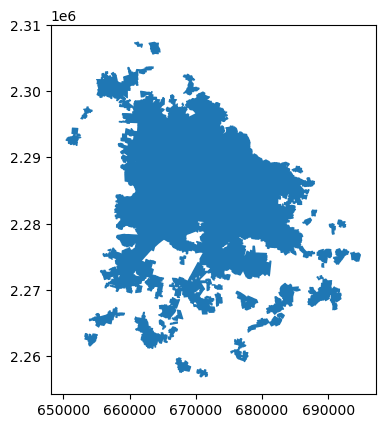

In [6]:
blocks_buffer.plot()

### __Load data__ - Network

In [7]:
# ----- ----- ----- Time start
time_1 = time.time()
# ----- ----- ----- Process
# Load nodes
nodes_gdf = gpd.read_file(nodes_dir)
# Set crs
if nodes_gdf.crs != projected_crs:
    nodes_gdf = nodes_gdf.to_crs(projected_crs)
    print(f"Changed crs to {projected_crs}.")
# Filter for data of interest
nodes_gdf = nodes_gdf[['osmid','x','y','geometry']]
# ----- ----- ----- Time end
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds.")

# Show
print(nodes_gdf.crs)
print(nodes_gdf.info())
nodes_gdf.head(2)

TIME: 0.7268354892730713 seconds.
EPSG:32613
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 124621 entries, 0 to 124620
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   osmid     124621 non-null  int64   
 1   x         124621 non-null  float64 
 2   y         124621 non-null  float64 
 3   geometry  124621 non-null  geometry
dtypes: float64(2), geometry(1), int64(1)
memory usage: 3.8 MB
None


,osmid,x,y,geometry
0,67637870229114485,676378.709485,2.291145e+06,POINT (676378.709 2291144.858)
1,67640019229114922,676400.196372,2.291149e+06,POINT (676400.196 2291149.223)


## Create voronoi polygons using nodes

In [8]:
print(f"--- Creating voronois with nodes osmid data.")

#Time start
time_1 = time.time()
#Process
voronois_gdf = src.voronoi_points_within_aoi(area_of_interest=blocks_buffer,
                                             points=nodes_gdf,
                                             points_id_col='osmid',
                                             projected_crs=projected_crs)
#Time end
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds.")

# Show
print(voronois_gdf.crs)
print(voronois_gdf.info())
voronois_gdf.head(2)

--- Creating voronois with nodes osmid data.
Error = 0.0%. Admissible.
TIME: 373.58073377609253 seconds.
EPSG:4326
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 115837 entries, 0 to 115836
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   osmid     115837 non-null  int64   
 1   geometry  115837 non-null  geometry
dtypes: geometry(1), int64(1)
memory usage: 1.8 MB
None


,osmid,geometry
0,65394725226151578,"POLYGON ((-103.52396 20.44653, -103.52287 20.4..."
1,67016094225777232,"POLYGON ((-103.36859 20.4107, -103.36869 20.41..."


<Axes: >

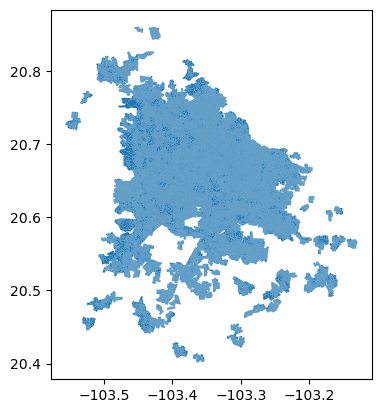

In [9]:
voronois_gdf.plot()

## Assign blocks population data to voronois

In [10]:
# Prepare voronois_gdf for function src.assing_blocks_attribute_to_voronoi()
voronois_gdf_prep = voronois_gdf.copy()

# Set crs
if voronois_gdf_prep.crs != projected_crs:
    voronois_gdf_prep = voronois_gdf_prep.to_crs(projected_crs)
    print(f"Changed crs to {projected_crs}.")
# Set index if necessary
if 'osmid' in voronois_gdf_prep.columns:
    original_len = len(voronois_gdf_prep)
    voronois_gdf_prep = voronois_gdf_prep.drop_duplicates(subset=['osmid'])
    new_len = len(voronois_gdf_prep)
    voronois_gdf_prep.set_index('osmid',inplace=True)
    print(f"Dropped {new_len-original_len} nodes to set osmid as nodes index.")

# Show
print(voronois_gdf_prep.shape)
voronois_gdf_prep.head(2)

Changed crs to EPSG:32613.
Dropped 0 nodes to set osmid as nodes index.
(115837, 1)


,geometry
osmid,
65394725226151578,"POLYGON ((653974.51 2261588.625, 654089.052 22..."
67016094225777232,"POLYGON ((670224.748 2257775.742, 670214.613 2..."


In [11]:
# Show
print(blocks_gdf.shape)
blocks_gdf.head(2)

(54804, 2)


,pobtot,geometry
cvegeo_mza,,
1412000620299011,16,"POLYGON ((659974.886 2297605.164, 659923.165 2..."
1412000620299032,18,"POLYGON ((659879.976 2297823.117, 659923.355 2..."


In [12]:
print(f"--- Assigning pop col {pop_col} from blocks to voronois .")

#Time start
time_1 = time.time()
#Process
voronois_pop_gdf = src.assing_blocks_attribute_to_voronoi(blocks_gdf, voronois_gdf_prep, attribute_column=pop_col)
#Time end
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds.")

# Show
print(voronois_pop_gdf.shape)
voronois_pop_gdf.head(2)

--- Assigning pop col pobtot from blocks to voronois .
TIME: 16.44074273109436 seconds.
(115837, 3)


,osmid,geometry,pobtot
0,65394725226151578,"POLYGON ((653974.51 2261588.625, 654089.052 22...",5
1,67016094225777232,"POLYGON ((670224.748 2257775.742, 670214.613 2...",0


## Calculate pop density in nodes (Using it's voronoi polygon's area)

In [13]:
print("--- Adding density using each voronoi polygon's area.")
# Set crs
if voronois_pop_gdf.crs != projected_crs:
    voronois_pop_gdf = voronois_pop_gdf.to_crs(projected_crs)
# Calculate whole voronoi's area
voronois_pop_gdf['area_has'] = voronois_pop_gdf.area/10000
# Calculate density
voronois_pop_gdf['dens_pob_ha'] = voronois_pop_gdf[pop_col] / voronois_pop_gdf['area_has']

# Show
print(voronois_pop_gdf.shape)
voronois_pop_gdf.head(2)

--- Adding density using each voronoi polygon's area.
(115837, 5)


,osmid,geometry,pobtot,area_has,dens_pob_ha
0,65394725226151578,"POLYGON ((653974.51 2261588.625, 654089.052 22...",5,2.479128,2.016838
1,67016094225777232,"POLYGON ((670224.748 2257775.742, 670214.613 2...",0,1.627780,0.000000


## Save voronoi polygons with population and density data

In [14]:
print(f"Original blocks gdf had {blocks_gdf.pobtot.sum()} habs. When dividing to voronois found {voronois_pop_gdf.pobtot.sum()} habs.")
print(f"Difference of {voronois_pop_gdf.pobtot.sum() - blocks_gdf.pobtot.sum()} habs.")

Original blocks gdf had 5011955 habs. When dividing to voronois found 5010542 habs.
Difference of -1413 habs.


In [16]:
if local_save:
    print("--- Saving result locally.")
    voronois_pop_gdf.to_file(output_dir+f"guadalajara_voronois_pop_gdf_b.gpkg")
    print("--- Result saved.")

--- Saving result locally.
--- Result saved.
